In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12741
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[B8 59 00 58 38 5...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[90 59 10 5A 20 5...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[E0 55 00 58 E0 5...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[50 57 90 55 A0 5...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[A0 56 F0 56 A0 5...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+-------------

In [4]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [5]:
from YearPlotter import YearPlotter 
YP=YearPlotter()
import matplotlib.pyplot  as plt 


In [6]:
print STAT['TMIN'].keys()
# plot_valid(['TMIN'],plot_valid,'Mean')

['std', 'UnDef', 'E', 'Cov', 'high1000', 'NE', 'O', 'low100', 'NO', 'high100', 'eigvec', 'low1000', 'Var', 'eigval', 'mean', 'SortedVals', 'Mean']


#### Plotting Mean with stddev

In [7]:
def plot_pair(pair,func,metric=None):
    j=0
    fig,X=subplots(len(pair)/2,2,figsize=(20,6*len(pair)/2))
#     print X
    axes=X.reshape(len(pair))
    for m in pair:
        axis = axes[j]
        j+=1
        if not metric:
            func(m,fig,axis)
        else:
            func(m,fig,axis,metric[m],m)
def plot_valid(m,fig,axis,metric='mean'):
    valid_m=STAT[m][metric]
    YP.plot(valid_m,fig,axis,title='mean-counts '+m)
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=['mean-std','mean','mean+std'])
def plot_mean(m,fig,axis,metric,name):
    year = metrics[name]['year'].tolist()
    metric = metrics[name]['avg(mean)'].tolist()
    year = [year[i] for i in range(0,len(year)-1,2)]
    metric = [(metric[i]+metric[i+1])*1.0/2 for i in range(0,len(metric)-1,2)]
    axis.plot(year,metric)
    axis.set_title(name)
    axis.grid()
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
#     plt.show()
#     YP.plot(metric,fig,axis,title=name)


In [8]:

# print df.rdd.map(lambda x: (x.measurement,1)).take(1)
t = df.rdd.map(lambda x: (x['measurement'],(1,x['year'],x['year']))).reduceByKey(lambda x,y: (x[0]+y[0],min(x[1],y[1]),max(x[2],y[2]))).collect()
print t
for x in t:
    STAT[x[0]]['count'] = x[1][0]
    STAT[x[0]]['min_year'] = x[1][1]
    STAT[x[0]]['max_year'] = x[1][2]
print df.count()

[(u'PRCP', (2926, 1893.0, 2012.0)), (u'TMIN', (2172, 1893.0, 2012.0)), (u'SNWD', (2111, 1903.0, 2012.0)), (u'TMAX', (2179, 1893.0, 2012.0)), (u'SNOW', (2190, 1903.0, 2012.0)), (u'TOBS', (1163, 1901.0, 2012.0))]
12741


- Tell the various measurements and number of rows for each with min year, max year, mean, variance etc
- Tell the number of stations, plot geographically
- For each measurement plot mean +- , mean per year
- Variation of tem range in a day
- For each measurement, eigen vectors, variance explained
- For interesting measurements ....

In [9]:
new_stat = {}

for key in ['mean','count','min_year','max_year','std']:
    new_stat[key] = {}
    for meas in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
        new_stat[key][meas] = STAT[meas][key]
pd.DataFrame(new_stat)

,count,max_year,mean,min_year,std
PRCP,2926,2012.0,13.243168,1893.0,53.703672
SNOW,2190,2012.0,0.038023,1903.0,1.809626
SNWD,2111,2012.0,0.079378,1903.0,3.945152
TMAX,2179,2012.0,212.951815,1893.0,67.244406
TMIN,2172,2012.0,79.742748,1893.0,46.878581
TOBS,1163,2012.0,151.848046,1901.0,67.942107


In [10]:
print df.select('station').distinct().count()
d_station= df.select(['station','longitude','latitude']).distinct()
print d_station.rdd.map(lambda x : (x['latitude'],x['latitude'],x['longitude'],x['longitude'])).reduce(lambda x,y : (min(x[0],y[0]),max(x[1],y[1]),min(x[2],y[2]),max(x[3],y[3])))

142
(36.1872, 37.4767, -122.4433, -120.8667)


In [11]:
min_lat,max_lat,min_long,max_long = box = (36.1872, 37.4767, -122.4433, -120.8667)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in d_station.toPandas().iterrows():
    _lat=row['latitude']
    _long=row['longitude']
#     _count=row['count(station)']
#     _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), 
                     radius=15, weight=5,
                    color='#F00', opacity=0.8, fill_opacity=0.4,
#                     fill_color=get_color(_coef)
                    )
    circles.append(c)
    m.add_layer(c)
m    

In [12]:
rows=df.rdd.map(lambda row: Row(year=row.year,measurement=row.measurement,
                                mean=float(np.nanmean(unpackArray(row['vector'],np.float16).astype('float64')))))

In [13]:
from pyspark.sql import functions as func

In [14]:

_df=rows.toDF()
_df.show(1)
metrics = {}
for meas in ['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']:
    metrics[meas]=_df.filter(_df['measurement'].like(meas)).groupBy(_df.year).agg(func.col('year'), func.mean('mean')).sort(_df.year).select(['year','avg(mean)']).toPandas()

+-----------------+-----------+------+
|             mean|measurement|  year|
+-----------------+-----------+------+
|252.9366391184573|       TMAX|2002.0|
+-----------------+-----------+------+
only showing top 1 row



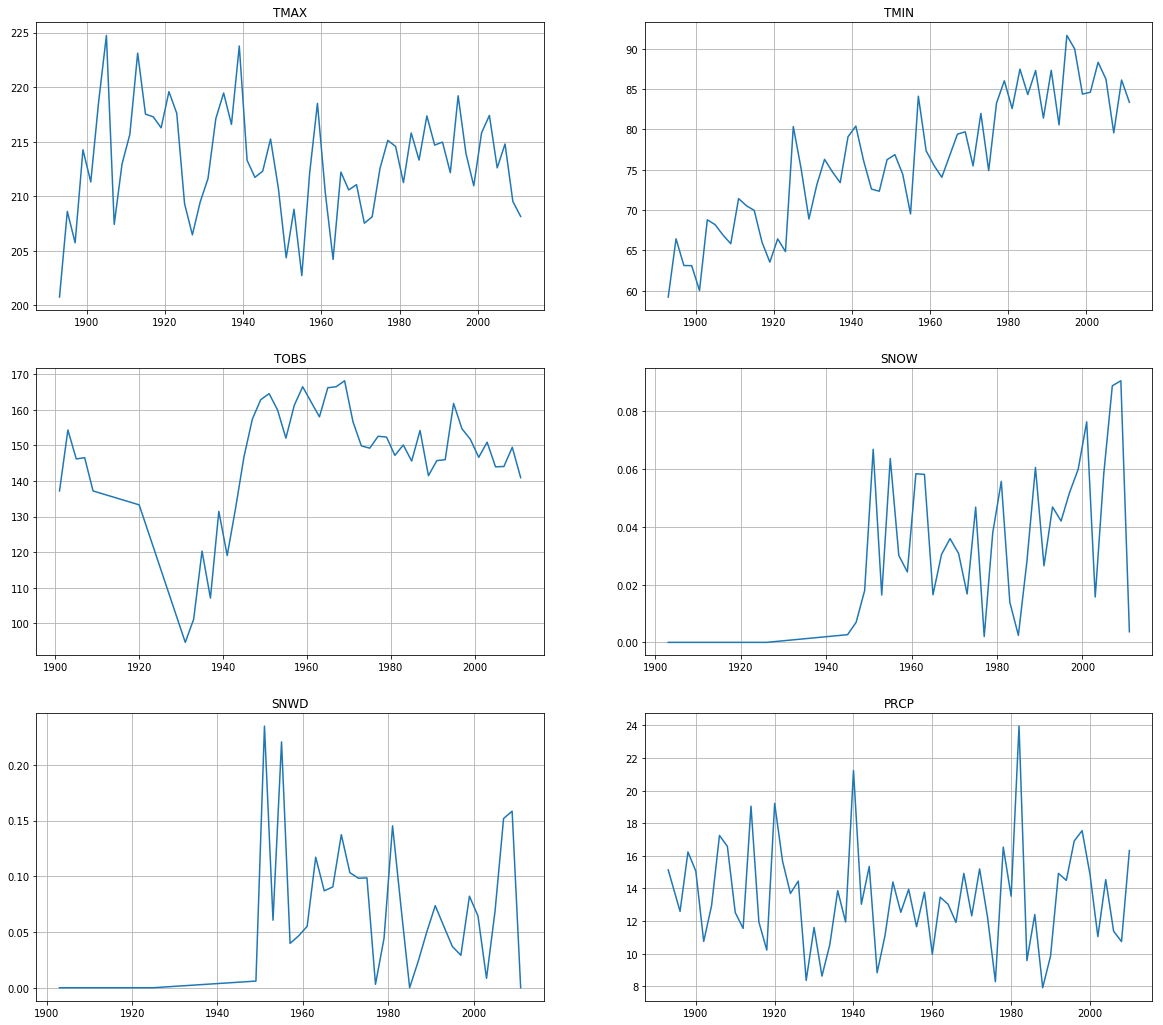

In [15]:
# print metrics['TMIN']#s
plot_pair(['TMAX',  'TMIN', 'TOBS','SNOW', 'SNWD', 'PRCP',],plot_mean,metrics)

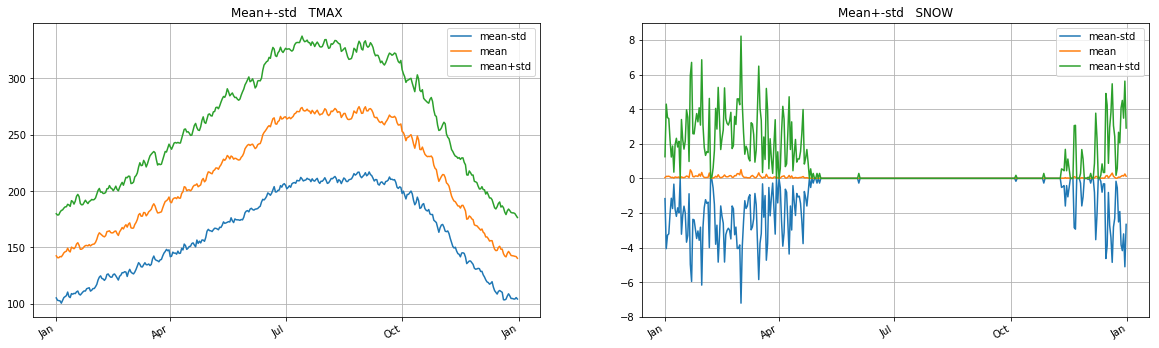

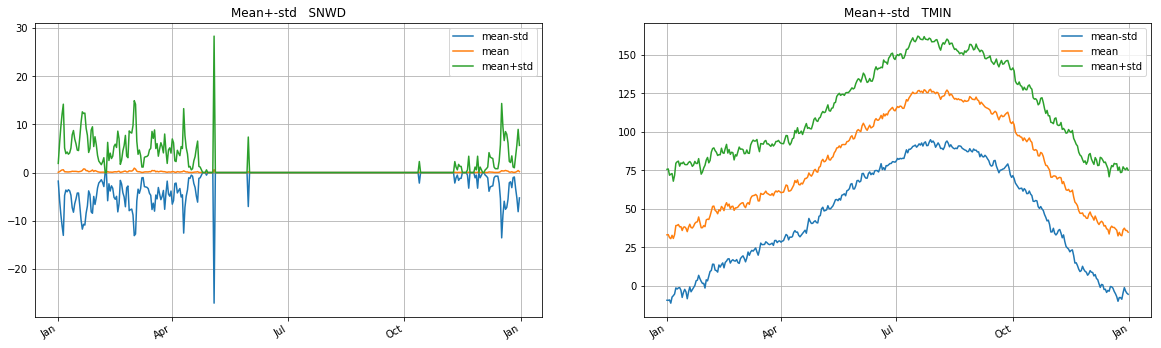

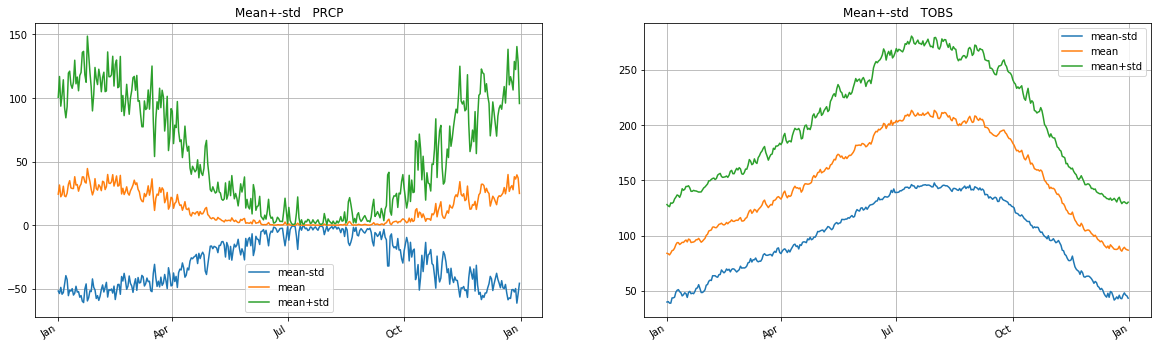

In [119]:
plot_pair(['TMAX', 'SNOW'],plot_mean_std)
plot_pair([ 'SNWD', 'TMIN'],plot_mean_std)
plot_pair(['PRCP', 'TOBS'],plot_mean_std)

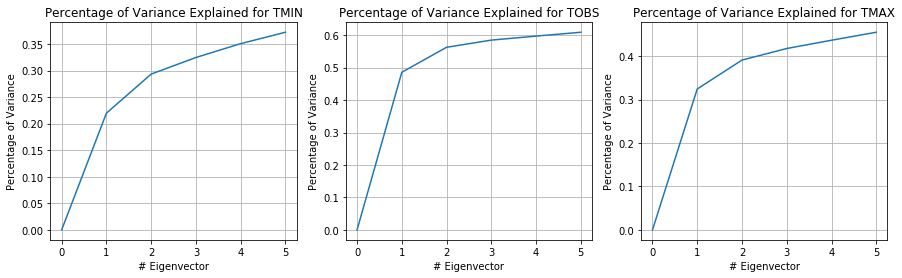

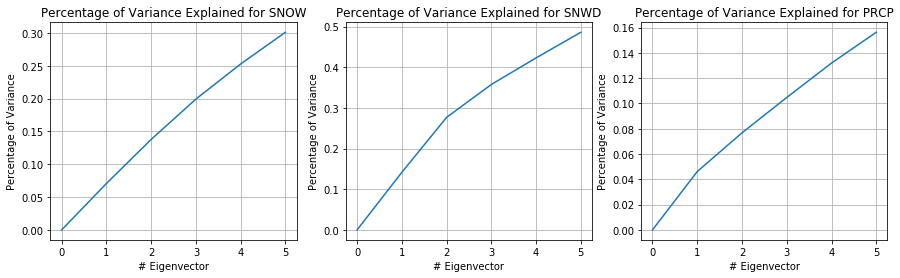

In [123]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
# plot_pair(['TMAX', 'SNOW'],plot_mean_std)
# plot_pair([ 'SNWD', 'TMIN'],plot_mean_std)
# plot_pair(['PRCP', 'TOBS'],plot_mean_std)

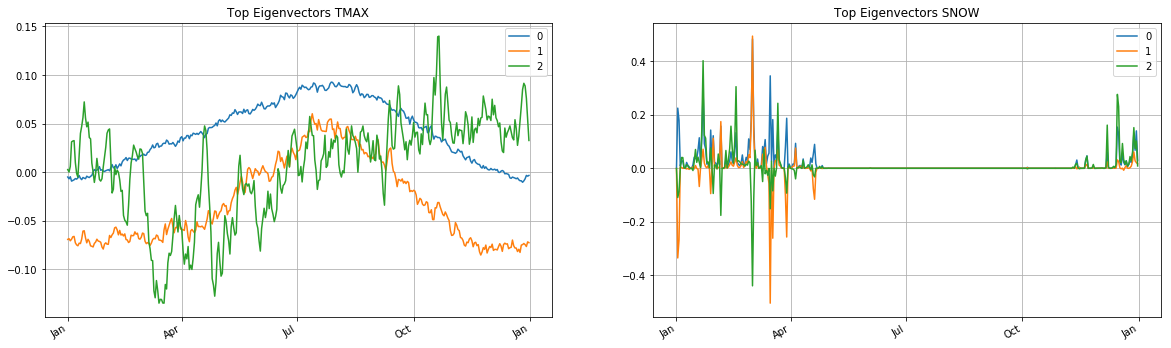

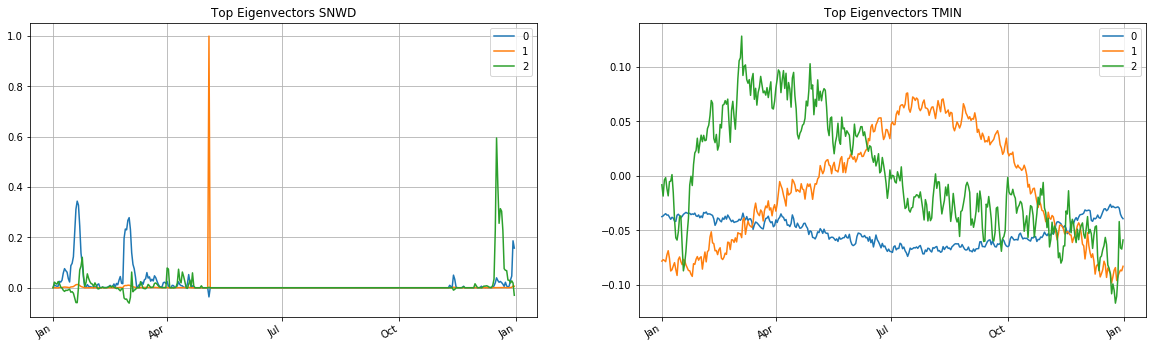

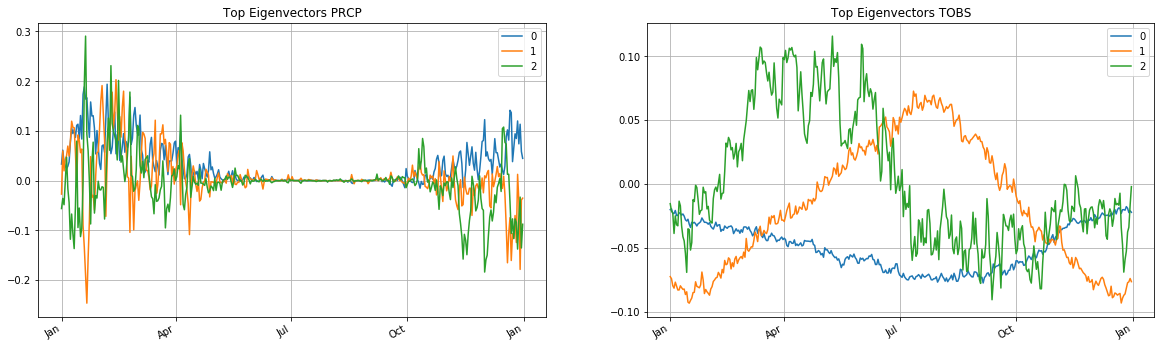

In [124]:
plot_pair(['TMAX', 'SNOW'],plot_eigen)
plot_pair([ 'SNWD', 'TMIN'],plot_eigen)
plot_pair(['PRCP', 'TOBS'],plot_eigen)